# Linear Regression Covariance
When conduction linear regression the coefficients in the model become random variables. The [slope](https://online.stat.psu.edu/stat200/lesson/7/7.4) in a linear regression is a Gausian random variable, which means that the coefficients are also Gausian. The regressed coefficients from a linear regression represent the mean values of these random variables, being the most likely values. But the random coefficients also have standard deviations which means that there are also other possible values for the coefficients, less likely, but still possible. And in some cases when the coefficients are very uncertain (high standard deviation) the other possible values are almost as likely, which means that we should also consider these as possible values for the coefficients. 

In this example we will fit a linear regression model using Ordinary Least Squares (OLS) on a generic dataset where the coefficients in the model are very uncertain due to multicollinearity which means that there is a high correlation between the variables (features) in the model. 

In [17]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path

import matplotlib
matplotlib.rcParams["figure.figsize"] = (15,4)
from src.symbols import *
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import norm, multivariate_normal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This is the model that we think will fit the generic dataset:

In [18]:
C_1,C_2, x_1, x_2, y = sp.symbols("C_1 C_2 x_1 x_2 y")
epsilon_1, epsilon_2, z = sp.symbols("epsilon_1 epsilon_2 z")
eq_linear = sp.Eq(y, C_1*x_1 + C_2*x_2)
eq_linear

Eq(y, C_1*x_1 + C_2*x_2)

$C_1$ is a coefficient connected to the variable (feature) $x_1$ and $C_2$ is the same thing for $x_2$.

In [19]:
solution = sp.solve(eq_linear, y, dict=True)[0][y]
lambda_y = sp.lambdify(list(solution.free_symbols), solution)
lambda_y

<function _lambdifygenerated(C_2, x_2, C_1, x_1)>

We create the generic dataset where $x_1$ and $x_2$ both have some Gausian noise, $y$ is however calculated directly from the above equation.

In [6]:
scale = 2
epsilon_1_ = norm(loc=0, scale=scale)
epsilon_2_ = norm(loc=0, scale=scale)

C_1_ = 1 
C_2_ = 5 

N = 200
data = pd.DataFrame()
data['epsilon_1'] = epsilon_1_.rvs(N)
data['epsilon_2'] = epsilon_2_.rvs(N)

data['x_1'] = np.linspace(0,5,N) 
data['x_2'] = np.linspace(0,5,N)
data['x_1_measure'] = data['x_1'] + data['epsilon_1']
data['x_2_measure'] = data['x_2'] + data['epsilon_2']

np.random.seed(42)
data['y'] = lambda_y(C_1=C_1_, C_2=C_2_, x_1=data['x_1'], x_2=data['x_2'])


Plotting $x_1$ against $x_2$ show that there is a high correlation between these variables:

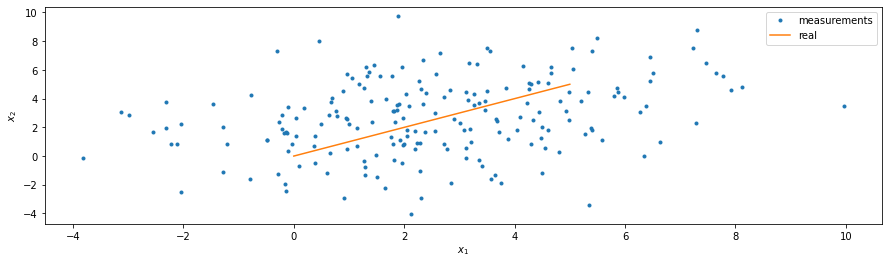

In [7]:
fig,ax=plt.subplots()
data.plot(x='x_1_measure', y='x_2_measure', style='.', label='measurements', ax=ax);
data.plot(x='x_1', y='x_2', style='-', label='real', ax=ax);
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

And here are $y$ values calculated from the noise measurements of $x_1$ and $x_2$:

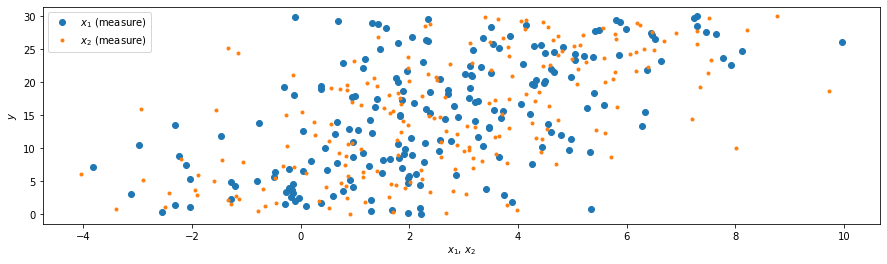

In [8]:
fig,ax=plt.subplots()
data.plot(x='x_1_measure', y='y', style='o', label='$x_1$ (measure)', ax=ax);
data.plot(x='x_2_measure', y='y', style='.', label='$x_2$ (measure)', ax=ax);

ax.set_xlabel('$x_1$, $x_2$')
ax.set_ylabel('$y$');

Regressing $C_1$ and $C_2$ on this generic dataset gives the following:

In [9]:
X = pd.DataFrame(index=data.index)
X['C_1'] = data['x_1_measure']
X['C_2'] = data['x_2_measure']

model = sm.OLS(data['y'], X, hasconst=True)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     69.12
Date:                Thu, 10 Feb 2022   Prob (F-statistic):           1.47e-14
Time:                        10:56:08   Log-Likelihood:                -686.59
No. Observations:                 200   AIC:                             1377.
Df Residuals:                     198   BIC:                             1384.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C_1            2.4085      0.203     11.869      0.000       2.008       2.809
C_2            2.3243      0.190     12.248      0.000       1.950       2.699
==============================================================================
Omnibus:                        1.966   Durbin-Watson:                   1.549
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                1.924
Skew:                           0.238   Prob(JB):                        0.382
Kurtosis:                       2.929   Cond. No.                         2.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We used $C_1=1$ , $C_2=5$ when we created the generic data but the regression has predicted $C_1=2.6	$ , $C_2=2.3$ but we can also see that the standard deviation ```std err``` is high, so the predicted coefficients are very uncertain. 

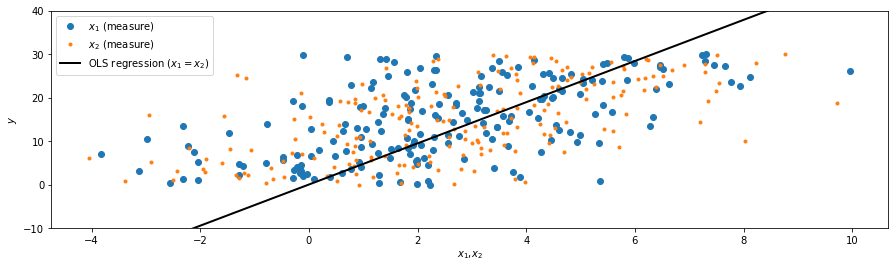

In [10]:
x_ = np.linspace(data['x_1_measure'].min(),data['x_1_measure'].max(),2)


fig,ax=plt.subplots()
data.plot(x='x_1_measure', y='y', style='o', label='$x_1$ (measure)', ax=ax);
data.plot(x='x_2_measure', y='y', style='.', label='$x_2$ (measure)', ax=ax);

y_pred = lambda_y(x_1=x_, x_2=x_, **result.params)
ax.plot(x_,y_pred,'k-', alpha=1, lw=2, zorder=10, label='OLS regression $(x_1=x_2)$')
    
ax.set_ylim(-10,40)
ax.set_xlabel('$x_1$,$x_2$')
ax.set_ylabel('$y$')
ax.legend();

The random variables $C_1$ and $C_2$ are Gausian and come from a Normal distribution with mean value and standrad deviation. With two or more random variables a multivariate normal distribution is used. The contour plot from this multivariate normal distribution with mean values and standard deviation from the regression is shown below:

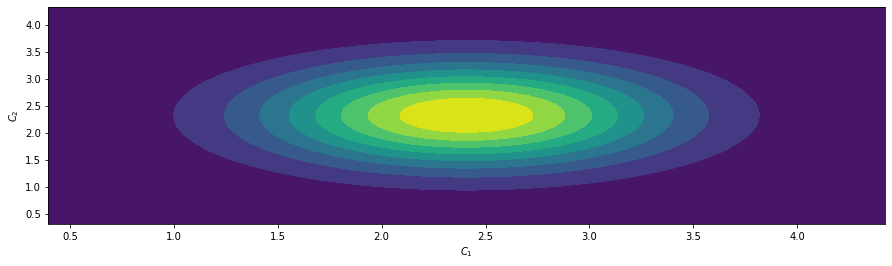

In [12]:
cov2 = np.diag(np.sqrt(result.bse))
rv2 = multivariate_normal(mean=result.params, cov=cov2)

N_ = 50
dx_ = 3*np.sqrt(cov2.max().max())
x_1_ = np.linspace(result.params['C_1'] - dx_ , result.params['C_1'] + dx_,N_)
x_2_ = np.linspace(result.params['C_2'] - dx_ , result.params['C_2'] + dx_,N_)


X1,X2 = np.meshgrid(x_1_, x_2_)
xs = np.array([X1.flatten(),X2.flatten()])
ls = rv2.pdf(xs.T)
L = ls.reshape(X1.shape)

from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
fig,ax=plt.subplots()
ax.contourf(X1,X2,L,levels=10)
ax.set_xlabel('$C_1$')
ax.set_ylabel('$C_2$');

For this case $C_1$ and $C_2$ are treated as independet random variables, which means that if $C_1$ has a high value, this will not influence the likelihood that $C_2$ can also have a high value. This is however not true in our problem. If $C_1$ is very large: 1000, $C_2$ can not also be very large, then the initial model will not add upp.

The regression also predicts the covariance of the random variables, also containing the dependency between $C_1$ and $C_2$. The contour plot of the distribution now looks like:

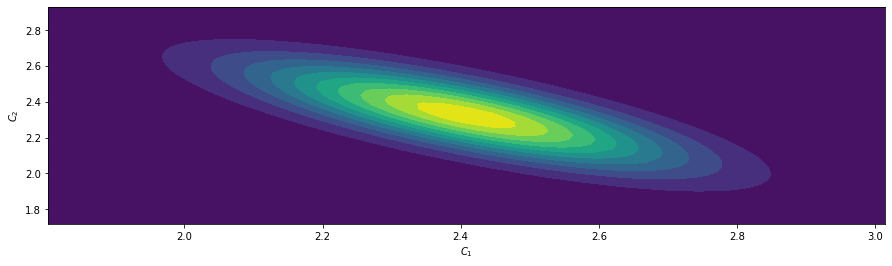

In [13]:
cov = result.cov_HC0
rv = multivariate_normal(mean=result.params, cov=cov)

N_ = 50
dx_ = 3*np.sqrt(cov.max().max())
x_1_ = np.linspace(result.params['C_1'] - dx_ , result.params['C_1'] + dx_,N_)
x_2_ = np.linspace(result.params['C_2'] - dx_ , result.params['C_2'] + dx_,N_)


X1,X2 = np.meshgrid(x_1_, x_2_)
xs = np.array([X1.flatten(),X2.flatten()])
ls = rv.pdf(xs.T)
L = ls.reshape(X1.shape)

from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
fig,ax=plt.subplots()
ax.contourf(X1,X2,L,levels=10)
ax.set_xlabel('$C_1$')
ax.set_ylabel('$C_2$');



It can now be seen that if $C_1$ is large then it is more likely that $C_2$ will be small.

We can take random samples from these multivariate distributions to simulate alternative realizations of this model. Sampling from a distribution with independent variables (only mean and standard deviation) and a distribution with dependent variables (mean and covariance) is shown below.

In [14]:
N_=50
df_Cs_rv = pd.DataFrame(rv.rvs(N_), columns=['C_1','C_2'])
df_Cs_rv2 = pd.DataFrame(rv2.rvs(N_), columns=['C_1','C_2'])

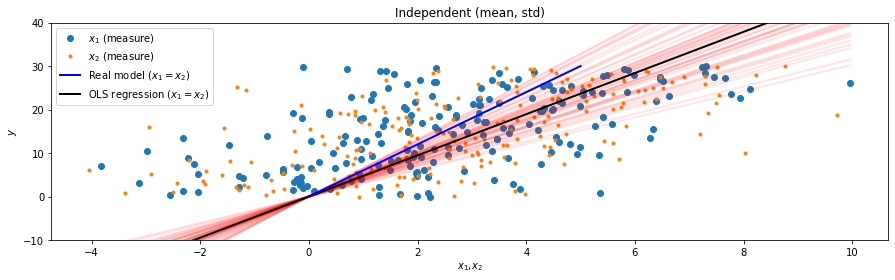

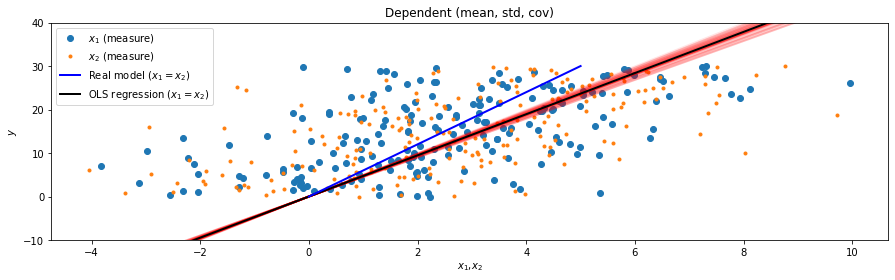

In [15]:
titles = ['Independent (mean, std)', 'Dependent (mean, std, cov)']

x_ = np.linspace(data['x_1_measure'].min(),data['x_1_measure'].max(),2)
for df_Cs,title in zip([df_Cs_rv2,df_Cs_rv],titles):

    fig,ax=plt.subplots()
    data.plot(x='x_1_measure', y='y', style='o', label='$x_1$ (measure)', ax=ax);
    data.plot(x='x_2_measure', y='y', style='.', label='$x_2$ (measure)', ax=ax);
    
    data.plot(x='x_1',y='y', style='b-', ax=ax, alpha=1, lw=2, zorder=12, label='Real model $(x_1=x_2)$')
    
    y_pred = lambda_y(x_1=x_, x_2=x_, **result.params)
    ax.plot(x_,y_pred,'k-', alpha=1, lw=2, zorder=10, label='OLS regression $(x_1=x_2)$')
    
    for index, Cs in df_Cs.iterrows():
        
        y_pred = lambda_y(x_1=x_, x_2=x_, **Cs)
        ax.plot(x_,y_pred,'r-', alpha=0.1, lw=2)
        
    ax.set_ylim(-10,40)
    ax.set_xlabel('$x_1$,$x_2$')
    ax.set_ylabel('$y$')
    ax.set_title(title)
    ax.legend()

The alternative models from the multivariate distribution with dependent variables have less spread. The "Real model" that was used to generate the generic data is however very different. Only when sampling from the distribution with independent variables, some of the solutions are close to the real model.

In this example it was impossible to identify which model that was the "Real model", because there were so many alternative models that could have created the same data. In fact the generic data is more likely originating from the regressed model, than the one we actually used. To better handle the multicollinearity it is most likely better to redefine the regression model as:

$y=C_1*(x_1+x_2)$

In [16]:
X2 = pd.DataFrame(index=data.index)
X2['C_1'] = data['x_1_measure'] + data['x_2_measure']

model = sm.OLS(data['y'], X2, hasconst=True)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 10 Feb 2022   Prob (F-statistic):                nan
Time:                        10:56:10   Log-Likelihood:                -686.62
No. Observations:                 200   AIC:                             1375.
Df Residuals:                     199   BIC:                             1379.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C_1            2.3647      0.080     29.437      0.000       2.206       2.523
==============================================================================
Omnibus:                        1.936   Durbin-Watson:                   1.545
Prob(Omnibus):                  0.380   Jarque-Bera (JB):                1.898
Skew:                           0.236   Prob(JB):                        0.387
Kurtosis:                       2.927   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Final words
This model has the same prediction accuracy, but only one coefficient with higher certainty. 
So when regressing a model "less is more" is perhaps a good rule in terms of adding coefficients and complexity to the model and this is true for Vessel Manoeuvring Models as well. 

For heavy metal the reversed is however still true, perhaps best quoted by Mr Yngwie Malmsteen :-).
<iframe width="560" height="315" src="https://www.youtube.com/embed/QHZ48AE3TOI" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>